# 1. Use the NestMLP model defined in Section 6.1 and access the parameters of the various layers.

In [5]:
import torch.nn as nn
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.LazyLinear(64), nn.ReLU(),
                                 nn.LazyLinear(32), nn.ReLU())
        self.linear = nn.LazyLinear(16)

    def forward(self, X):
        return self.linear(self.net(X))

model = NestMLP()
[name for name, param in model.net.named_parameters()]

['0.weight', '0.bias', '2.weight', '2.bias']

# 2. Construct an MLP containing a shared parameter layer and train it. During the training process, observe the model parameters and gradients of each layer.

In [5]:
import sys
import torch.nn as nn
import torch
import warnings
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
warnings.filterwarnings("ignore")

class PlotParameterMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, dropouts):
        super().__init__()
        self.save_hyperparameters()
        layers = [nn.Flatten(),nn.LazyLinear(num_hiddens[0]),nn.ReLU()]
        shared = nn.LazyLinear(num_hiddens[1])
        self.activations = []
        for i in range(1,len(num_hiddens)):
            layers.append(shared)
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropouts[i]))
            self.activations.append(i*3)
        layers.append(nn.LazyLinear(num_outputs))
        self.net = nn.Sequential(*layers)
        
    def training_step(self, batch, plot_flag=True):
        y_hat = self(*batch[:-1])
        # auc = torch.tensor(roc_auc_score(batch[-1].detach().numpy() , y_hat[:,1].detach().numpy()))
        if plot_flag:
            for i in self.activations:
                # print(self.net[i].weight.data,self.net[i].weight.grad)
                self.plot(f'layer_{i}_weight',self.net[i].weight.data.mean(),train=True)
                # self.plot(f'layer_{i}_weight',self.net[i].weight.grad.mean(),train=True)
        return self.loss(y_hat, batch[-1])
        
    def validation_step(self, batch, plot_flag=True):
        y_hat = self(*batch[:-1])
        # auc = torch.tensor(roc_auc_score(batch[-1].detach().numpy() , y_hat[:,1].detach().numpy()))
        if plot_flag:
            for i in self.activations:
                # self.plot(f'layer_{i}_weight',self.net[i].weight.data.mean(),train=True)
                self.plot(f'layer_{i}_weight',self.net[i].weight.grad.mean(),train=True)
        return self.loss(y_hat, batch[-1])
    
    def stat_activation_variance(self, i, X):
        activation = self.net[:i](X)
        return ((activation-activation.mean(axis=0,keepdim=True))**2).mean()

(118.06766620278358, 24.128756165504456)

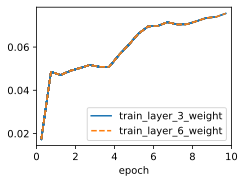

In [2]:
data = d2l.FashionMNIST(batch_size=256)
hparams = {'num_outputs':10,'num_hiddens':[8]*3,
           'dropouts':[0]*3,'lr':0.1}
model = PlotParameterMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# 3. Why is sharing parameters a good idea?

Sharing parameters in a neural network can be a good idea for several reasons:

1. **Reduced Model Size:** Sharing parameters reduces the number of unique parameters in the model, which can lead to a more compact model representation. This is especially important when dealing with limited computational resources or memory constraints.

2. **Improved Generalization:** Sharing parameters encourages weight sharing across different parts of the network, promoting regularization and preventing overfitting. It enforces a form of parameter tying, which helps the model generalize better to unseen data.

3. **Transfer Learning:** Sharing parameters enables transfer learning, where a pre-trained model on one task can be fine-tuned or adapted for a related task with less labeled data. The shared parameters capture general features that can be useful for multiple tasks.

4. **Learning from Limited Data:** When training data is limited, sharing parameters allows the model to leverage information from multiple similar examples, leading to improved learning from a small dataset.

5. **Invariance and Abstraction:** Shared parameters can capture high-level features that are invariant across different parts of the input space, leading to the extraction of abstract representations that are beneficial for various tasks.

6. **Faster Convergence:** Sharing parameters can help the model converge faster because it can learn common patterns more effectively. This can be particularly helpful in cases where training resources are limited.

7. **Interpretable Representations:** Shared parameters can lead to learned features that are more interpretable and meaningful, making it easier to understand what the model is learning.

8. **Simpler Architectures:** Sharing parameters can simplify the architecture of the model by reducing the need for separate weights for similar tasks or components. This can lead to easier model design and maintenance.

9. **Efficient Resource Usage:** Shared parameters allow you to use the same set of weights for multiple instances of a module, saving memory and computation during inference.

However, it's important to carefully consider which parameters to share and under what conditions. Not all parts of a neural network can or should share parameters. It depends on the task, the data, and the architectural choices. Sharing too many parameters or sharing inappropriately can lead to poor performance or failed convergence. Therefore, it's crucial to analyze the problem, experiment with different parameter-sharing strategies, and monitor the model's performance to ensure that parameter sharing is indeed beneficial.